# Reading and understanding the data

In [1]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from chemception.chemception import Chemception
from chemception.Featurizer import ChemCeptionizer
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau

train_df = pd.read_csv('data/train_aid686978_0.3.csv')
# train_df = train_df.sample(frac=0.2)
train_df.head()

,smiles,label
0,O=C(CCCC(=O)Nc1cccc(Br)c1)NNC=C1C=C([N+](=O)[O...,1.0
1,CSCCC(C(=O)Nc1ccc2c(c1)OCCO2)N1Cc2ccccc2C1=O,0.0
2,C=C(C)Cn1c(N(CCO)Cc2ccccc2)nc2c1c(=O)[nH]c(=O)n2C,0.0
3,Fc1ccccc1COc1ccc(Br)cc1CNCC1CCCO1,1.0
4,Cc1ccc(C)c(CN2C(=O)c3ccccc3S(=O)(=O)c3ccc(C(=O...,1.0


`SMILES` are a way to represent molecules as strings. This represenation is a standard in the Chemistry community and is usually parsed to other representaions of the molecule. For example, the `RDKit` library can parse SMILES to a `Mol` object.

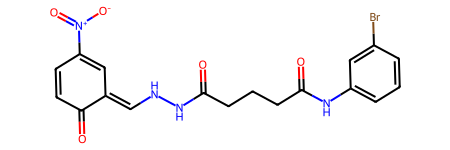

In [2]:
Chem.MolFromSmiles(train_df['smiles'].iloc[0])

We will use this represntation as a first step for our featurization. We will use the `RDKit` library to parse the SMILES to a `Mol` object for all the data.

In [3]:
train_df["mol"] = train_df["smiles"].apply(Chem.MolFromSmiles)

# Featurizing

The featurization process is the backbone of the paper we adopted, the paper chose certain feature that well describe the molecule and used them as features for the model. Which is inline with what we have learned in picking features for our data.

Since we are using a `CNN` Model, our featurization method will be dependent on an image represtnation of the molecule. However, we do some feature engineering that extract important aspects of the molecule (`bonds order`, `atom types`, `hybridization`, and `gasteiger charges`) and use them as features for our model.


![Alt text](images/Featurizer.png)

In [4]:
# This is the featurizer we used, can be found in Featurizer.py
featureizer = ChemCeptionizer(embed=20, fuse=True)

# Featurize the molecules
train_df["molimage"] = train_df["mol"].apply(featureizer.featurize)
# pd.to_pickle(train_df, "train_df.pkl")

# train_df = pd.read_pickle("train_df.pkl")


In [5]:
# train_df.dropna(inplace=True)
# for i in train_df['molimage']:
#     f = i.flatten()
#     if np.nan in f:
#         print("nan")
#         break

### Visualize the results of the featurization process

In [6]:
# def show_channel(v, channel_ind):
#     """
#     Show a single channel of a 3D numpy array
#     """
#     v_copy = np.zeros(shape=(v.shape[0], v.shape[1], 3))
#     if channel_ind >= 3:
#         v_copy[:,:,0] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
#     else:
#         v_copy[:,:,channel_ind] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
        
#     return v_copy


# sample = train_df["molimage"].iloc[1]
# plt.imshow(sample)
# ch1, ch2, ch3 = show_channel(sample, 0), show_channel(sample, 1), show_channel(sample, 2)
# fig, ax = plt.subplots(2, 2, figsize=(15, 15))
# ax[0, 0].imshow(ch1)
# ax[0, 1].imshow(ch2)
# ax[1, 0].imshow(ch3)
# # ax[1, 1].imshow(ch4)
# ax[0, 0].set_title("Bond Channel")
# ax[0, 1].set_title("Atomic Number Channel")
# ax[1, 0].set_title("Hybridization Channel")
# # ax[1, 1].set_title("Gasteiger Charge Channel")

Text(0.5, 1.0, 'Molecule')

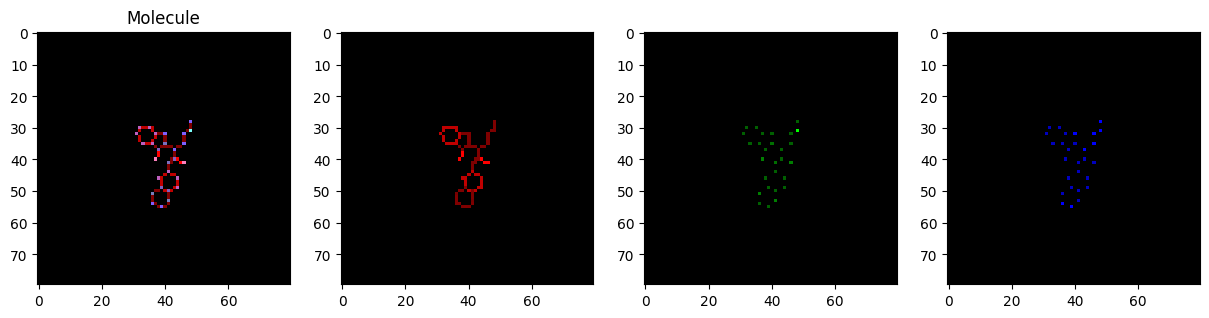

In [7]:
def show_channel(v, channel_ind):
    """
    Show a single channel of a 3D numpy array
    """
    v_copy = np.zeros(shape=(v.shape[0], v.shape[1], 3))
    if channel_ind >= 3:
        v_copy[:,:,0] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
    else:
        v_copy[:,:,channel_ind] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
        
    return v_copy


sample = train_df["molimage"].iloc[1]
ch1, ch2, ch3 = show_channel(sample, 0), show_channel(sample, 1), show_channel(sample, 2)
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(sample)
ax[1].imshow(ch1)
ax[2].imshow(ch2)
ax[3].imshow(ch3)
ax[0].set_title("Molecule")

# ax[1, 1].set_title("Gasteiger Charge Channel")

The featurization is working correctly, we proceed to model building

# Model Building

The model was adpoted directly from the paper with `N` being selected as `32`

### `Block Architecture`
![Alt text](images/model_block_arch.png)

In [8]:
# from keras.optimizers import Adam
# model = Chemception(N=256, reductionA_count=0, reductionB_count=0)
# model = model.build()
# model.compile(optimizer=Adam(learning_rate=.05), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

# Preparing generator and data for fitting

![Alt text](images/Featurizer.png)
It can be observed from the above image the orientation difference between the original image and our featurization result. Since our featurization method in recontructing the molecule image using our selected features, we can assure the `0` intra-class variation, hence, we do not need augmentation.

In [9]:
# import keras
# from keras.layers import Flatten

# def Inception0(input):
#     tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
#     tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
#     tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
 
#     output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
#     return output

# def Inception(input):
#     tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
#     tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
#     tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
#     tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
 
#     output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
#     return output



# input_img = Input(shape=X_train.shape[1:])
 
# x = Inception0(input_img)
# x = Inception(x)
# x = Inception(x)
# od=int(x.shape[1])
# x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
# x = Flatten()(x)
# x = Dense(100, activation='relu')(x)
# output = Dense(1, activation='sigmoid')(x)
 
# model = Model(inputs=input_img, outputs=output)
# optimizer = Adam(lr=0.00025)
# model.compile(loss="binary_crossentropy", optimizer=optimizer)
# model.summary()

In [10]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(data_format='channels_last')

train_df.dropna(subset=["molimage"], inplace=True)
X_train = train_df["molimage"].to_numpy()
X_train = np.stack(X_train, axis=0)
y_train = train_df["label"]

batch_size=32
g = generator.flow(X_train, y_train, batch_size=batch_size, shuffle=True)



# Fit the model

#### Load validation data

In [11]:
val_df = pd.read_csv('data/val_aid686978_0.3.csv')
# val_df = val_df.sample(frac=0.2)
val_df['mol'] = val_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
val_df['molimage'] = val_df['mol'].apply(featureizer.featurize)
val_df.dropna(subset=["molimage"], inplace=True)
X_val = val_df["molimage"].to_numpy()
X_val = np.stack(X_val, axis=0)
y_val = val_df["label"]

##### Optimal config from hyperband and baysian optimization
{'config': {'dense_layers': 3,
  'dropout': 0.2,
  'embed': 25,
  'lr': 5e-06,
  'neurons': 256},
 'config_info': {'model_based_pick': True}}

In [12]:
#reload modules
%load_ext autoreload
%autoreload 2

from chemception.chemception_transfer import Chemception
from keras.optimizers import Adam
model = Chemception(neurons=512, dropout=0.0, dense_layers=1, img_size=80)
model = model.build()
model.compile(optimizer=Adam(learning_rate= 0.5e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (

In [13]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.layers import Input

# Define the input shape for your data
input_shape = (80, 80, 3)

# Load the InceptionV3 model, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

# Add a final output layer with sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(x)

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of all layers in the InceptionV3 model except the last two
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
model.fit(g, epochs=50, steps_per_epoch=len(X_train)/64, validation_data=(X_val, y_val), callbacks=[early_stopping])
model.save('chemception_transfer.h5')

Epoch 1/50


2023-04-25 05:32:14.383187: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


409/409 [==============================] - 22s 47ms/step - loss: 0.6850 - accuracy: 0.6031 - val_loss: 0.6468 - val_accuracy: 0.6243
Epoch 2/50
409/409 [==============================] - 17s 40ms/step - loss: 0.6512 - accuracy: 0.6207 - val_loss: 0.6420 - val_accuracy: 0.6443
Epoch 3/50
409/409 [==============================] - 16s 40ms/step - loss: 0.6474 - accuracy: 0.6264 - val_loss: 0.6471 - val_accuracy: 0.6320
Epoch 4/50
409/409 [==============================] - 17s 42ms/step - loss: 0.6449 - accuracy: 0.6307 - val_loss: 0.6410 - val_accuracy: 0.6379
Epoch 5/50
409/409 [==============================] - 128s 314ms/step - loss: 0.6458 - accuracy: 0.6281 - val_loss: 0.6405 - val_accuracy: 0.6334
Epoch 6/50
209/409 [==============>...............] - ETA: 8s - loss: 0.6426 - accuracy: 0.6384

KeyboardInterrupt: 

In [ ]:

# steps_per_epoch = X_train.shape[0]//batch_size
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=1e-6, verbose=1)


# history = model.fit(g,
#                     steps_per_epoch=steps_per_epoch,
#                     epochs=100, verbose=2,
#                     validation_data=(X_val, y_val),
#                     callbacks=[reduce_lr]
#                     )

In [ ]:
model.fit(g, epochs=200, steps_per_epoch=len(X_train)/64, validation_data=(X_val, y_val))
model.save('chemception_transfer_train.h5')

In [ ]:
model.evaluate(X_val, y_val)

59/59 [==============================] - 2s 26ms/step - loss: 0.6450 - accuracy: 0.6260


[0.6449547410011292, 0.6260032057762146]

# Plot the history

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'loss')
plt.legend()
plt.yscale("log")

NameError: name 'history' is not defined

# Test the model on test data

In [ ]:
test_df = pd.read_csv('data/test_aid686978_0.3.csv')
# test_df = test_df.sample(frac=0.2)
test_df['mol'] = test_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
test_df['molimage'] = test_df['mol'].apply(featureizer.featurize)
test_df.dropna(subset=["molimage"], inplace=True)
X_test = np.array(list(test_df["molimage"]))
y_test = test_df["label"]

[19:29:03] WARNING: not removing hydrogen atom without neighbors


In [ ]:
model.evaluate(X_test, y_test)

58/58 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5033


[0.693132221698761, 0.5032538175582886]

# Kernel Visualization

# Comparing other models

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from deepchem.feat import CircularFingerprint

featurizer = CircularFingerprint(size=1024)
X_train, y_train = featurizer.featurize(train_df["smiles"]), train_df["label"]
X_val, y_val = featurizer.featurize(val_df["smiles"]), val_df["label"]
# X_test, y_test = featurizer.featurize(test_df["smiles"]), test_df["label"]

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

rf.score(X_train, y_train)

0.8079477782867613

### Graph Convolutional Network

In [ ]:
y_train.to_numpy().astype(int)

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
from deepchem.models import GraphConvModel
from deepchem.feat import ConvMolFeaturizer
import deepchem as dc

featurizer = ConvMolFeaturizer()
X_train, y_train = featurizer.featurize(train_df["smiles"]), train_df["label"]
X_val, y_val = featurizer.featurize(val_df["smiles"]), val_df["label"]
# X_test, y_test = featurizer.featurize(test_df["smiles"]), test_df["label"]

dataset = dc.data.NumpyDataset(X_train, y_train)
model = GraphConvModel(n_tasks=1, mode='classification', dropout=0.2)
model.fit(dataset)

model.evaluate(dataset)

NotFoundError: Graph execution error:

Detected at node 'gradient_tape/private__graph_conv_keras_model_6/graph_gather_6/and' defined at (most recent call last):
    File "/opt/miniconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/miniconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/miniconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/miniconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/miniconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/7n/ynz1z7qd3fbg7568r_zgsb980000gn/T/ipykernel_43252/2823185961.py", line 12, in <module>
      model.fit(dataset)
    File "/opt/miniconda3/lib/python3.9/site-packages/deepchem/models/keras_model.py", line 351, in fit
      return self.fit_generator(
    File "/opt/miniconda3/lib/python3.9/site-packages/deepchem/models/keras_model.py", line 441, in fit_generator
      batch_loss = apply_gradient_for_batch(inputs, labels, weights, loss)
    File "/opt/miniconda3/lib/python3.9/site-packages/deepchem/models/keras_model.py", line 507, in apply_gradient_for_batch
      grads = tape.gradient(batch_loss, vars)
Node: 'gradient_tape/private__graph_conv_keras_model_6/graph_gather_6/and'
No registered 'BroadcastTo' OpKernel for 'GPU' devices compatible with node {{node gradient_tape/private__graph_conv_keras_model_6/graph_gather_6/and}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_BOOL, Tidx=DT_INT32, _XlaHasReferenceVars=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"
	.  Registered:  device='XLA_CPU_JIT'; Tidx in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, 930109355527764061, DT_HALF, DT_UINT32, DT_UINT64, DT_FLOAT8_E5M2, DT_FLOAT8_E4M3FN]
  device='GPU'; T in [DT_FLOAT]
  device='DEFAULT'; T in [DT_INT32]
  device='CPU'; T in [DT_UINT64]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_UINT32]
  device='CPU'; T in [DT_UINT16]
  device='CPU'; T in [DT_INT16]
  device='CPU'; T in [DT_UINT8]
  device='CPU'; T in [DT_INT8]
  device='CPU'; T in [DT_INT32]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_BOOL]
  device='CPU'; T in [DT_STRING]
  device='CPU'; T in [DT_RESOURCE]
  device='CPU'; T in [DT_VARIANT]

	 [[gradient_tape/private__graph_conv_keras_model_6/graph_gather_6/and]] [Op:__inference_apply_gradient_for_batch_55543]